In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import plot_losses, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, crop
from csng.losses import SSIMLoss, MSELossWithCrop, Loss
from csng.readins import MultiReadIn, FCReadIn, ConvReadIn

from cat_v1_spiking_model.dataset_50k.data import (
    prepare_v1_dataloaders,
    SyntheticDataset,
    BatchPatchesDataLoader,
    MixedBatchLoader,
    PerSampleStoredDataset,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
print(f"{DATA_PATH=}")

DATA_PATH='/home/sobotj11/decoding-brain-activity/data/cat_V1_spiking_model/50K_single_trial_dataset'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    # "crop_win": (slice(15, 35), slice(15, 35)),
    "crop_win": (20, 20),
    "only_cat_v1_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()

### V1 dataset (spiking model of cat V1)

In [5]:
config["data"]["cat_v1"] = {
    "train_path": os.path.join(DATA_PATH, "datasets", "train"),
    "val_path": os.path.join(DATA_PATH, "datasets", "val"),
    "test_path": os.path.join(DATA_PATH, "datasets", "test"),
    "image_size": [50, 50],
    "crop": False,
    "batch_size": 14,
    "stim_keys": ("stim",),
    "resp_keys": ("exc_resp", "inh_resp"),
    "return_coords": True,
    "return_ori": False,
    "coords_ori_filepath": os.path.join(DATA_PATH, "pos_and_ori.pkl"),
    "cached": False,
    "stim_normalize_mean": 46.143,
    "stim_normalize_std": 20.420,
    "resp_normalize_mean": torch.load(
        os.path.join(DATA_PATH, "responses_mean.pt")
    ),
    "resp_normalize_std": torch.load(
        os.path.join(DATA_PATH, "responses_std.pt")
    ),
}

In [6]:
### get data loaders
dataloaders["cat_v1"] = prepare_v1_dataloaders(**config["data"]["cat_v1"])

Train dataset size: 45000. Validation dataset size: 5000. Test dataset size: 250.


stim.shape=torch.Size([14, 1, 50, 50]), resp.shape=torch.Size([14, 46875])
stim.min()=tensor[] -2.260, stim.max()=tensor[] 2.637
resp.min()=tensor[] -2.408, resp.max()=tensor[] 17.007
stim.mean()=tensor[] 0.039, stim.std()=tensor[] 1.200
resp.mean()=tensor[] -0.007, resp.std()=tensor[] 1.075
coords.shape=torch.Size([14, 46875, 2]), coords.dtype=torch.float32
coords.min()=tensor[] -2.500, coords.max()=tensor[] 2.500


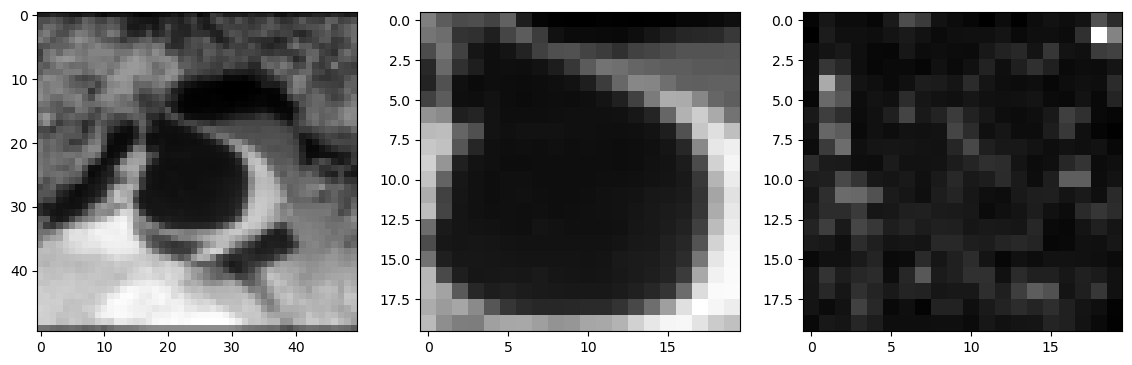

In [7]:
### show data
datapoint = next(iter(dataloaders["cat_v1"]["val"]))
stim, resp, coords = datapoint.images, datapoint.responses, datapoint.neuron_coords
coords = coords.float()
print(
    f"{stim.shape=}, {resp.shape=}"
    f"\n{stim.min()=}, {stim.max()=}"
    f"\n{resp.min()=}, {resp.max()=}"
    f"\n{stim.mean()=}, {stim.std()=}"
    f"\n{resp.mean()=}, {resp.std()=}"
    f"\n{coords.shape=}, {coords.dtype=}"
    f"\n{coords.min()=}, {coords.max()=}"
    # f"\n{ori.min()=}, {ori.max()=}"
)

### plot sample data
sample_idx = 0
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx], config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

# ax = fig.add_subplot(133)
# ax.imshow(resp[0].view(125, 375).squeeze(0).unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 20, 20 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[sample_idx,:,0].min().item(), coords[sample_idx,:,0].max().item(), coords[sample_idx,:,1].min().item(), coords[sample_idx,:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[sample_idx,:,0]) &\
               (coords[sample_idx,:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[sample_idx,:,1]) &\
               (coords[sample_idx,:,1] < y_bins[j + 1])
        binned_resp[j,i] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

plt.show()

### Synthetic data (different stimuli dataset -> encoder -> neuronal responses)

In [ ]:
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data", "responses_mean.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data", "responses_std.npy"))).float()

config["data"]["syn_data"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=114.457,
            std=51.356,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 20,
        "shuffle": True,
    }
}

In [ ]:
syn_datasets = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "train"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "val"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "test"),
        **config["data"]["syn_data"]["dataset"]
    ),
}

dataloaders["syn_data"] = {
    "train": DataLoader(
        dataset=syn_datasets["train"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets["val"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets["test"],
        **config["data"]["syn_data"]["dataloader"],
    ),
}

In [ ]:
### calculate statistics

### for stimuli
# syn_stats = get_mean_and_std(dataset=syn_dataset, verbose=True)
# syn_stats

### for responses
# from csng.utils import RunningStats

# stats = RunningStats(num_components=10000, lib="torch", device="cuda")
# for i, (s, r) in enumerate(syn_dataloader):
#     stats.update(r)
#     if i % 200 == 0:
#         print(f"{i}: {r.mean()=} {r.std()=} {stats.get_mean()=} {stats.get_std()=}")

### save
# torch.save(stats.get_mean(), os.path.join(DATA_PATH, "responses_mean_from_syn_dataset.pt"))
# torch.save(stats.get_std(), os.path.join(DATA_PATH, "responses_std_from_syn_dataset.pt"))


### generate preprocessed synthetic data
# import pickle
# target_dir = os.path.join(DATA_PATH, "synthetic_data", "processed")

# for data_split in ("train", "val", "test"):
#     print(data_split)
#     ### get the whole batch from dataloaders and save to disk
#     sample_idx = 0
#     for stim, resp in syn_dataloaders[data_split]:
#         if sample_idx % 2000 == 0:
#             print("  ", sample_idx)
        
#         for i in range(stim.shape[0]):
#             sample_idx += 1
#             save_to = os.path.join(target_dir, data_split, f"{sample_idx}.pickle")

#             data = {"stim": stim[i].cpu(), "resp": resp[i].cpu()}
#             with open(save_to, "wb") as f:
#                 pickle.dump(data, f)

In [ ]:
### show data
syn_stim, syn_resp = next(iter(dataloaders["syn_data"]["val"]))
print(
    f"{syn_stim.shape=}, {syn_resp.shape=}"
    f"\n{syn_stim.min()=}, {syn_stim.max()=}"
    f"\n{syn_resp.min()=}, {syn_resp.max()=}"
    f"\n{syn_stim.mean()=}, {syn_stim.std()=}"
    f"\n{syn_resp.mean()=}, {syn_resp.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim.cpu()[0], config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

### Synthetic data (V1 data stimuli -> encoder -> neuronal responses)

In [ ]:
### load
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "responses_mean_original.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "responses_std_original.npy"))).float()

config["data"]["syn_data_v1_enc"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=0,
            std=1,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 30,
        "shuffle": True,
    }
}

In [ ]:
syn_datasets_v1_encoder = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "train"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "val"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "test"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
}

dataloaders["syn_data_v1_enc"] = {
    "train": DataLoader(
        dataset=syn_datasets_v1_encoder["train"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets_v1_encoder["val"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets_v1_encoder["test"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
}

In [ ]:
### show data
syn_stim_v1_enc, syn_resp_v1_enc = next(iter(dataloaders["syn_data_v1_enc"]["val"]))
print(
    f"{syn_stim_v1_enc.shape=}, {syn_resp_v1_enc.shape=}"
    f"\n{syn_stim_v1_enc.min()=}, {syn_stim_v1_enc.max()=}"
    f"\n{syn_resp_v1_enc.min()=}, {syn_resp_v1_enc.max()=}"
    f"\n{syn_stim_v1_enc.mean()=}, {syn_stim_v1_enc.std()=}"
    f"\n{syn_resp_v1_enc.mean()=}, {syn_resp_v1_enc.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim_v1_enc.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim_v1_enc.cpu()[0], config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp_v1_enc.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

## Decoder

In [8]:
def train(model, dataloader, opter, loss_fn, config, verbose=True):
    model.train()
    train_loss = 0
    n_batches = len(dataloader)
    
    ### run
    # for batch_idx, (stim, resp, coords, ori) in enumerate(dataloader):
    for batch_idx, b in enumerate(dataloader):
        opter.zero_grad()
        loss = 0

        ### combine from all data keys
        for data_key, (stim, resp, neuron_coords) in b.items():
            ### data
            stim = stim.to(config["device"])
            resp = resp.to(config["device"])
            neuron_coords = neuron_coords.float().to(config["device"])
        
            ### train
            stim_pred = model(resp, data_key=data_key, neuron_coords=neuron_coords)
            loss += loss_fn(stim_pred, stim, phase="train")
            model.set_additional_loss(
                inp={
                    "resp": resp,
                    "stim": stim,
                    "neuron_coords": neuron_coords,
                    "data_key": data_key,
                }, out={
                    "stim_pred": stim_pred,
                },
            )
            loss += model.get_additional_loss(data_key=data_key)
        
        ### update
        loss /= len(b)
        loss.backward()
        opter.step()

        ### log
        train_loss += loss.item()
        if verbose and batch_idx % 100 == 0:
            print(f"Training progress: [{batch_idx}/{n_batches} ({100. * batch_idx / n_batches:.0f}%)]"
                  f"  Loss: {loss.item():.6f}")

    train_loss /= n_batches
    return train_loss

In [9]:
def val(model, dataloader, loss_fn, config):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch_idx, b in enumerate(dataloader):

            loss = 0

            ### combine from all data keys
            for data_key, (stim, resp, neuron_coords) in b.items():
                ### data
                stim = stim.to(config["device"])
                resp = resp.to(config["device"])
                neuron_coords = neuron_coords.float().to(config["device"])
            
                ### predict
                stim_pred = model(resp, data_key=data_key, neuron_coords=neuron_coords)
                loss += loss_fn(stim_pred, stim, phase="test")
                model.set_additional_loss(
                    inp={
                        "resp": resp,
                        "stim": stim,
                        "neuron_coords": neuron_coords,
                        "data_key": data_key,
                    }, out={
                        "stim_pred": stim_pred,
                    },
                )
                loss += model.get_additional_loss(data_key=data_key)

            ### log
            loss /= len(b)
            val_loss += loss.item()

    val_loss /= len(dataloader)
    return val_loss

In [10]:
def get_dataloaders(config, dataloaders, only_cat_v1_eval=True):
    ### get dataloaders to mix
    dataloaders_to_mix = [dl for dl in dataloaders.values()]

    ### get dataloaders
    train_dataloader = MixedBatchLoader(
        dataloaders=[dl["train"] for dl in dataloaders_to_mix],
        mixing_strategy=config["data"]["mixing_strategy"],
        device=config["device"],
        data_keys=["cat_v1" for _ in dataloaders_to_mix],
        return_pupil_center=False,
    )
    val_dataloader = MixedBatchLoader(
        dataloaders=[dl["val"] for dl in dataloaders_to_mix] \
            if not only_cat_v1_eval else [dataloaders["cat_v1"]["val"]],
        mixing_strategy=config["data"]["mixing_strategy"],
        device=config["device"],
        data_keys=["cat_v1" for _ in dataloaders_to_mix],
        return_pupil_center=False,
    )

    return train_dataloader, val_dataloader

In [12]:
config["decoder"] = {
    "model": {
        "readins_config": [
            {
                "data_key": "cat_v1",
                "in_shape": resp.shape[-1],
                "decoding_objective_config": None,
                "layers": [
                    (ConvReadIn, {
                        "H": 8,
                        "W": 8,
                        "shift_coords": False,
                        "learn_grid": True,
                        "grid_l1_reg": 8e-3,
                        "in_channels_group_size": 1,
                        "grid_net_config": {
                            "in_channels": 3, # x, y, resp
                            "layers_config": [("fc", 64), ("fc", 128), ("fc", 8*8)],
                            "act_fn": nn.LeakyReLU,
                            "out_act_fn": nn.Identity,
                            "dropout": 0.15,
                            "batch_norm": False,
                        },
                        "pointwise_conv_config": {
                            "in_channels": resp.shape[-1],
                            "out_channels": 256,
                            "act_fn": nn.Identity,
                            "bias": False,
                            "batch_norm": True,
                            "dropout": 0.1,
                        },
                        "gauss_blur": False,
                        "gauss_blur_kernel_size": 7,
                        "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                        # "gauss_blur_sigma": "per_neuron", # "fixed", "single", "per_neuron"
                        "gauss_blur_sigma_init": 1.5,
                        "neuron_emb_dim": None,
                    }),

                #     (FCReadIn, {
                #         "in_shape": d.n_neurons,
                #         "layers_config": [
                #             ("fc", 288),
                #             ("unflatten", 1, (2, 9, 16)),
                #         ],
                #         "act_fn": nn.LeakyReLU,
                #         "out_act_fn": nn.Identity,
                #         "batch_norm": True,
                #         "dropout": 0.15,
                #         "out_channels": 2,
                #     }),
                ],
            }
        ],
        "core_cls": CNN_Decoder,
        "core_config": {
            "resp_shape": [256],
            "stim_shape": list(stim.shape[1:]),
            "layers": [
                ### for conv_readin
                ("deconv", 128, 7, 2, 1),
                ("deconv", 64, 5, 1, 1),
                ("deconv", 32, 4, 1, 1),
                ("deconv", 1, 3, 1, 0),
            ],
            "act_fn": nn.ReLU,
            "out_act_fn": nn.Identity,
            "dropout": 0.25,
            "batch_norm": True,
        },
    },
    # "opter_cls": torch.optim.Adam,
    # "opter_kwargs": {
    #     # "lr": 0.001,
    #     "lr": 1e-4,
    # },
    "opter_cls": torch.optim.AdamW,
    "opter_kwargs": {
        "lr": 3e-4,
        "weight_decay": 0.03,
    },
    "loss": {
        # "loss_fn": nn.MSELoss(),
        # "loss_fn": MSELossWithCrop(window=config["crop_win"]),
        "loss_fn": SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        "l1_reg_mul": 0,
        # "l2_reg_mul": 5e-5,
        "l2_reg_mul": 0,
        "con_reg_mul": 0,
        # "con_reg_mul": 1,
        "con_reg_loss_fn": SSIMLoss(window=config["crop_win"], log_loss=True, inp_normalized=True, inp_standardized=False),
        "encoder": None,
        # "encoder": encoder,
    },
    "n_epochs": 200,
    "load_ckpt": None,
    # "load_ckpt": {
    #     "run_name": "2023-08-25_09-07-46",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2023-08-25_09-07-46", "ckpt", "decoder_40.pt"),
    # },
    "save_run": False,
}

decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])

[WARNING] resp_shape in core_config will be overwritten by the output of the last readin layer (shape 144)


In [13]:
### prepare checkpointing
if config["decoder"]["save_run"]:
    ### save config
    run_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    ckpts_dir = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22",
                             "models", "cat_v1_pretraining")
    config["dir"] = os.path.join(ckpts_dir, run_name)
    os.makedirs(config["dir"], exist_ok=True)
    with open(os.path.join(config["dir"], "config.json"), "w") as f:
        json.dump(config, f, indent=4, default=str)
    os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
    os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )

    print(f"Run name: {run_name}\nRun dir: {config['dir']}")
else:
    make_sample_path = lambda epoch, prefix: None
    print("WARNING: Not saving the run and the config.")

In [14]:
### load ckpt
if config["decoder"]["load_ckpt"] is not None:
    ### load ckpt
    run_name = config["decoder"]["load_ckpt"]["name"]  # "2023-08-25_09-07-46"
    ckpt = torch.load(os.path.join(DATA_PATH, "models", run_name, "ckpt", "decoder_40.pt"), pickle_module=dill)

    history = ckpt["history"]
    config = ckpt["config"]
    best = ckpt["best"]

    decoder = CNN_Decoder(**config["decoder"]["model"]).to(config["device"])
    decoder.load_state_dict(ckpt["decoder"])

    opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
    opter.load_state_dict(ckpt["opter"])

    loss_fn = config["decoder"]["loss_fn"]() if type(config["decoder"]["loss_fn"]) == type else config["decoder"]["loss_fn"]

    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )
else:
    history = {"train_loss": [], "val_loss": []}
    best = {"val_loss": np.inf, "epoch": 0, "model": None}

In [15]:
### print model
with torch.no_grad():
    print(decoder(resp.to(config["device"]), data_key="cat_v1", neuron_coords=coords.float().to(config["device"])).shape)
print(f"Number of parameters: {count_parameters(decoder)}")

decoder

torch.Size([14, 1, 24, 24])
Number of parameters: 3408817


MultiReadIn(
  (readins): ModuleDict(
    (cat_v1): ModuleList(
      (0): ConvReadIn(
        (pointwise_conv): Sequential(
          (0): Identity()
          (1): Conv2d(15625, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.01)
        )
        (grid_net): Sequential(
          (0): Linear(in_features=3, out_features=64, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=64, out_features=128, bias=True)
          (4): LeakyReLU(negative_slope=0.01)
          (5): Dropout(p=0.2, inplace=False)
          (6): Linear(in_features=128, out_features=64, bias=True)
          (7): Identity()
        )
      )
    )
  )
  (core): CNN_Decoder(
    (layers): Sequential(
      (0): ConvTranspose2d(144, 128, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
      (1): B

[1/200]
Training progress: [0/3214 (0%)]  Loss: 0.792005
Training progress: [100/3214 (3%)]  Loss: 0.720805
Training progress: [200/3214 (6%)]  Loss: 0.699562
Training progress: [300/3214 (9%)]  Loss: 0.723094
Training progress: [400/3214 (12%)]  Loss: 0.716017
Training progress: [500/3214 (16%)]  Loss: 0.713775
Training progress: [600/3214 (19%)]  Loss: 0.679015
Training progress: [700/3214 (22%)]  Loss: 0.681552
Training progress: [800/3214 (25%)]  Loss: 0.719268
Training progress: [900/3214 (28%)]  Loss: 0.643459
Training progress: [1000/3214 (31%)]  Loss: 0.577017
Training progress: [1100/3214 (34%)]  Loss: 0.528493
Training progress: [1200/3214 (37%)]  Loss: 0.461224
Training progress: [1300/3214 (40%)]  Loss: 0.446033
Training progress: [1400/3214 (44%)]  Loss: 0.436783
Training progress: [1500/3214 (47%)]  Loss: 0.405039
Training progress: [1600/3214 (50%)]  Loss: 0.390975
Training progress: [1700/3214 (53%)]  Loss: 0.357802
Training progress: [1800/3214 (56%)]  Loss: 0.369953
T

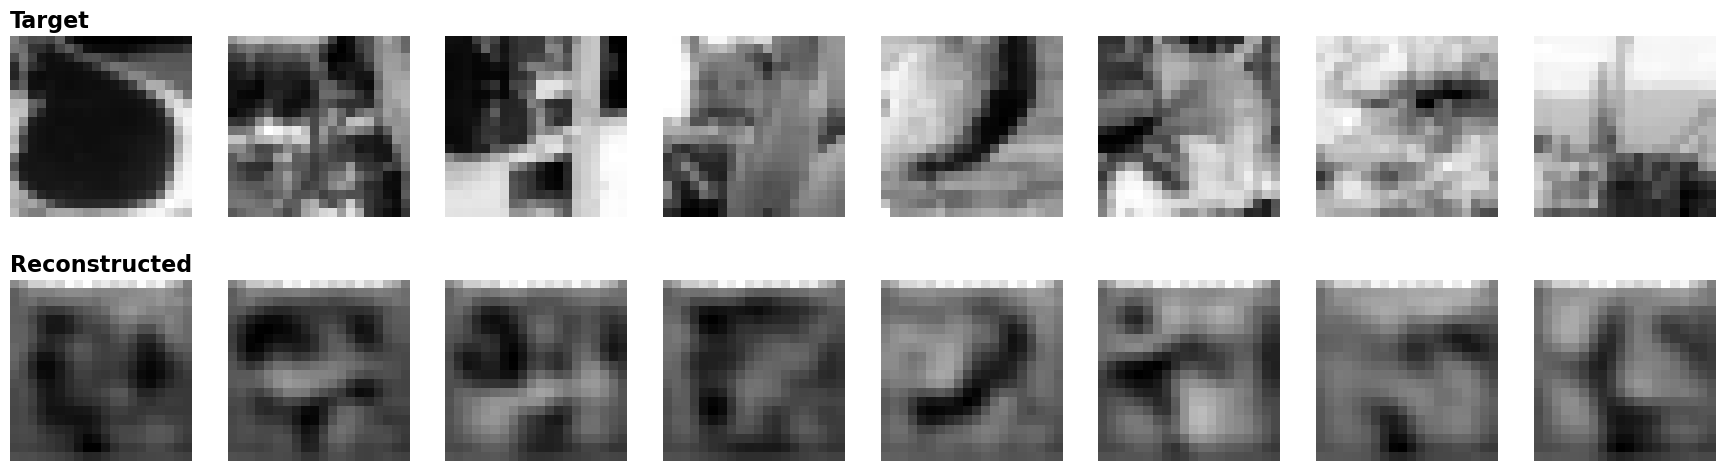

[2/200]
Training progress: [0/3214 (0%)]  Loss: 0.273549
Training progress: [100/3214 (3%)]  Loss: 0.258573
Training progress: [200/3214 (6%)]  Loss: 0.275106
Training progress: [300/3214 (9%)]  Loss: 0.259686
Training progress: [400/3214 (12%)]  Loss: 0.247355
Training progress: [500/3214 (16%)]  Loss: 0.284419


In [16]:
### train
s, e = len(history["train_loss"]), config["decoder"]["n_epochs"]
for epoch in range(s, e):
    print(f"[{epoch + 1}/{e}]")

    ### train and val
    train_dataloader, val_dataloader = get_dataloaders(
        config=config,
        dataloaders=dataloaders,
        only_cat_v1_eval=config["only_cat_v1_eval"],
    )
    train_loss = train(
        model=decoder,
        dataloader=train_dataloader,
        opter=opter,
        loss_fn=loss_fn,
        config=config,
    )
    val_loss = val(
        model=decoder,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
        config=config,
    )

    ### save best model
    if val_loss < best["val_loss"]:
        best["val_loss"] = val_loss
        best["epoch"] = epoch
        best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    print(f"{train_loss=:.4f}, {val_loss=:.4f}")

    ### plot reconstructions
    stim_pred = decoder(resp[:8].to(config["device"]), neuron_coords=coords[:8].to(config["device"]), data_key="cat_v1").detach()
    if "cat_v1" in config["data"] and config["data"]["cat_v1"]["crop"] == False:
        plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu(), save_to=make_sample_path(epoch, ""))
    else:
        plot_comparison(target=stim[:8].cpu(), pred=stim_pred[:8].cpu(), save_to=make_sample_path(epoch, "no_crop_"))

    ### plot losses + save ckpt
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history, epoch=epoch, save_to=os.path.join(config["dir"], f"losses_{epoch}.png") if config["decoder"]["save_run"] else None)

        ### ckpt
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "opter": opter.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"), pickle_module=dill)

In [ ]:
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "opter": opter.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"), pickle_module=dill)

### plot reconstructions of the final model
decoder.load_state_dict(best["model"])
stim_pred_best = decoder(resp[:8].to(config["device"]), neuron_coords=coords[:8].to(config["device"]), data_key="cat_v1").detach()
plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png")
)

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)